In [42]:
import os
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt

> Preprocess

In [43]:
# rewrite the raw selfie to 32*32 gray image
def Resize_selfie():
    selfie_dir = './selfie/'
    for index in os.listdir(selfie_dir):
        image_tmp = cv2.imread(os.path.join(selfie_dir,index))
        gray_image = cv2.cvtColor(image_tmp, cv2.COLOR_BGR2GRAY)
        resized_image = cv2.resize(gray_image, (32, 32))
        cv2.imwrite(f'./selfie/gray_resized_image_{index}.jpg', resized_image)

In [44]:
def Generate_raw_imgae():
    label_dir = './PIE/'
    dataset = pd.DataFrame(columns=['Faces','Label'])
    train_data = pd.DataFrame(columns=['Faces','Label'])
    test_data = pd.DataFrame(columns=['Faces','Label'])
    for index in os.listdir(label_dir)[0:25]:
        i = int(index)
        image_dir_tmp = os.path.join(label_dir,index)
        for image in os.listdir(image_dir_tmp):
            image_tmp = cv2.imread(os.path.join(image_dir_tmp,image),cv2.IMREAD_GRAYSCALE).flatten()
            dataset = dataset.append({'Faces':image_tmp, 'Label': i}, ignore_index=True)
    data_shuffle = dataset.sample(frac=1).reset_index(drop=True)
    split = int(data_shuffle.shape[0]*0.7)
    train_data = data_shuffle[:split]
    test_data = data_shuffle[split:]
            
    selfie_dir = './selfie/'
    selfie_image = []
    for index in os.listdir(selfie_dir)[0:7]:
        image_tmp = cv2.imread(os.path.join(selfie_dir,index),cv2.IMREAD_GRAYSCALE)
        dataset = dataset.append({'Faces':image_tmp.flatten(), 'Label': 69}, ignore_index=True)
        selfie_image.append(image_tmp)
    for index in os.listdir(selfie_dir)[7:]:
        image_tmp = cv2.imread(os.path.join(selfie_dir,index),cv2.IMREAD_GRAYSCALE)
        dataset = dataset.append({'Faces':image_tmp.flatten(), 'Label': 69}, ignore_index=True)
        selfie_image.append(image_tmp)
    
    # To save the variable and read it directly next time
    train_data.to_hdf('train.h5', key='mydata', mode='w')
    test_data.to_hdf('test.h5', key='mydata', mode='w')
    dataset.to_hdf('dataset.h5', key='mydata', mode='w')
    np.save('selfie_image.npy', np.array(selfie_image))
# Generate_raw_imgae()  #just use for the first time

In [45]:
dataset = pd.read_hdf('dataset.h5', key='mydata')
Label_chosen = dataset['Label'].unique()
Label_chosen = np.sort(Label_chosen)
print('The Label chosen is :\n',Label_chosen,
      '\n Len:',Label_chosen.shape[0],
      '\n and selfie number:69')
dataset.head()

The Label chosen is :
 [1 2 3 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 69] 
 Len: 26 
 and selfie number:69


,Faces,Label
0,"[36, 35, 35, 38, 41, 42, 41, 39, 37, 39, 43, 4...",1
1,"[91, 20, 25, 27, 48, 46, 42, 38, 41, 38, 34, 3...",1
2,"[88, 38, 16, 22, 21, 24, 28, 16, 21, 20, 25, 2...",1
3,"[92, 42, 18, 23, 22, 27, 32, 22, 26, 25, 31, 3...",1
4,"[43, 25, 13, 18, 25, 23, 19, 19, 18, 18, 40, 2...",1


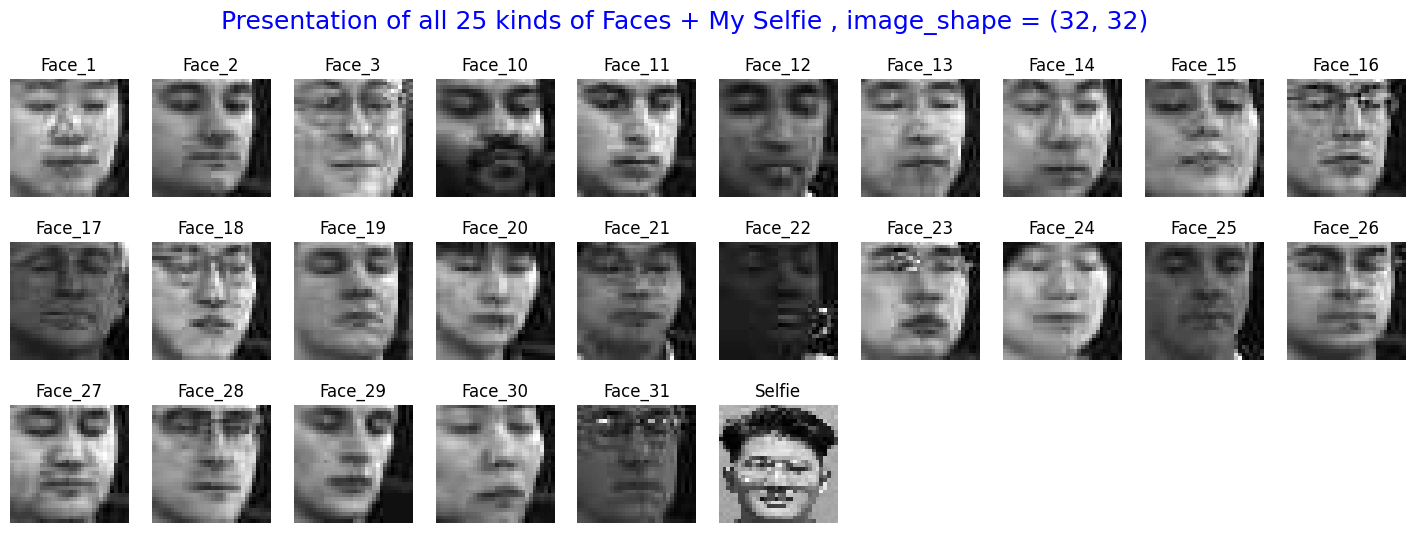

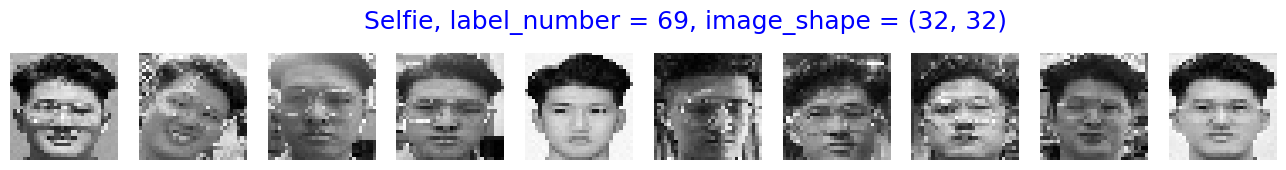

In [46]:
selfie_image = np.load('./selfie_image.npy')
plt.figure(figsize=(18, 6))
for i in range(1,26):
    plt.subplot(3,10,i)
    plt.imshow( dataset[dataset['Label'] == Label_chosen[i - 1]]['Faces'].iloc[0].reshape(32,32),
                cmap='gray' )
    plt.title(f'Face_{Label_chosen[i - 1]}')
    plt.axis('off')
plt.subplot(3,10,26)
plt.imshow( selfie_image[0],
            cmap='gray' )
plt.title('Selfie')
plt.axis('off')
plt.suptitle('Presentation of all 25 kinds of Faces + My Selfie , '+
             f'image_shape = (32, 32)',
             fontsize=18, color = 'b')
plt.show()

m, n = selfie_image[0].shape
plt.figure(figsize=(18, 2))
for i in range(10):
    plt.subplot(1,11,i +1)
    plt.imshow(selfie_image[i], cmap='gray')
    plt.axis('off')
plt.suptitle('Selfie, label_number = 69, '+
             f'image_shape = {m, n}',
             fontsize=18, color = 'b')
plt.show()

> 1. PCA based data distribution visualization

Randomly Sample 500 photos from TrainingSet

In [47]:
# take 500-7 faces from PIE and 7 selfies as Train
data = pd.read_hdf('train.h5', key='mydata').to_numpy()
np.random.shuffle(data)
n_select = 500
Selfie_select = 7
Labels = data[:n_select - Selfie_select,1]
n_pixel = dataset['Faces'][0].shape[0]
face_select = np.zeros((n_select, n_pixel))
for i in range(n_select - Selfie_select):
    face_select[i,:] = data[i,0]
for i in range(Selfie_select):
    face_select[n_select - Selfie_select + i,:] = selfie_image[i].flatten()
    Labels = np.append(Labels, 69)

test_data = pd.read_hdf('test.h5', key='mydata').to_numpy()
PIE_test = np.zeros((test_data.shape[0],1024))
for i in range(PIE_test.shape[0]):
    PIE_test[i,:] = test_data[i,0]
PIE_label = test_data[:,1]

face_train = face_select
Label_train = Labels
selfie_test = np.zeros((3,1024))
for i in range(3):
    selfie_test[i] = selfie_image[7 + i,:,:].flatten()
selfie_label = np.array([[69]*3])
print(
      'Name and Shape of Trainset and Testset:',
      '\n------------------------------------------------------------------',
      '\ntrain       : face_train   |   Label_train       | Shape:', 
      face_train.shape, Label_train.shape[0],
      '\ntest_PIE    : PIE_test     |   PIE_label         | Shape:',
      PIE_test.shape, PIE_label.shape[0],
      '\ntest_selfie : selfie_test  |   selfie_label      | Shape:',
      selfie_test.shape, selfie_label.shape[1]
      )

Name and Shape of Trainset and Testset: 
------------------------------------------------------------------ 
train       : face_train   |   Label_train       | Shape: (500, 1024) 500 
test_PIE    : PIE_test     |   PIE_label         | Shape: (1275, 1024) 1275 
test_selfie : selfie_test  |   selfie_label      | Shape: (3, 1024) 3


Function Defination Block

In [48]:
def PCA_SVD(input):
    mean = np.mean(input, axis=0)
    normalized_data = input - mean
    U, D, Vt = np.linalg.svd(normalized_data)
    U_ncom = U[:, :200]
    print('Matrix size:',
          '\n-',
          '\nU_ncom: ',U_ncom.shape,
          '\nD:',D.shape, 
          '\nVt:', Vt.shape)
    projected_data = np.dot(normalized_data, -Vt.T[:, : 200])
    print('Preojection_data:', projected_data.shape,
          '\n------------------------------------------------------------------')
    return projected_data, normalized_data, Vt
_, _, Vt = PCA_SVD(face_train)

Matrix size: 
- 
U_ncom:  (500, 200) 
D: (500,) 
Vt: (1024, 1024)
Preojection_data: (500, 200) 
------------------------------------------------------------------


In [49]:
def PCA_decomponent(img):
    img -= np.mean(img, axis=0)
    cov = np.dot(img.T, img)
    values,vecs = np.linalg.eig(cov)
    V = vecs
    vec = vecs[0:200]
    return vec

def PCA_projection(img, vec):
    img -= np.mean(img, axis=0)
    return img @ vec.T

vec = PCA_decomponent(img=face_train)

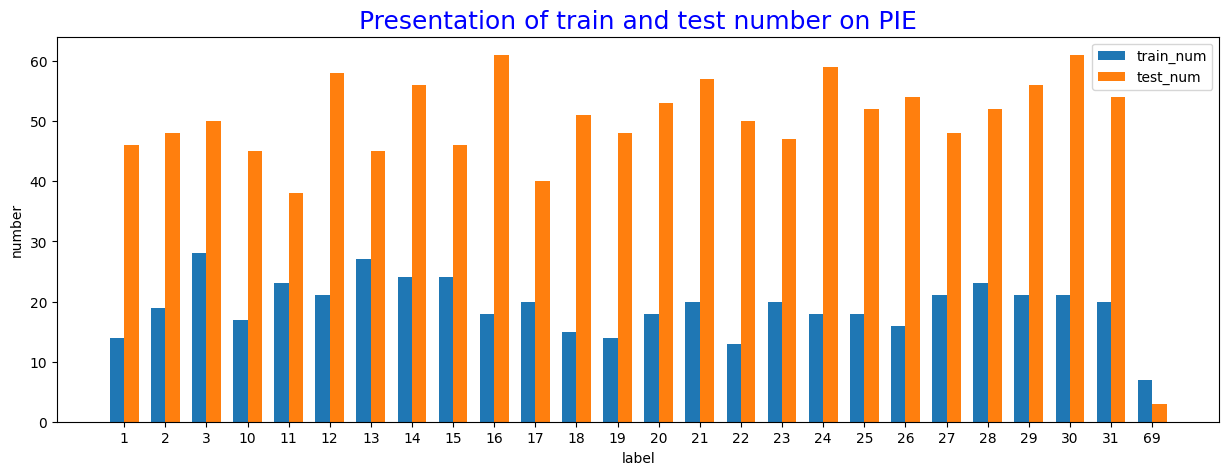

In [50]:
plt.figure(figsize=(15,5))
chosen_rate = []
train_num = []
test_num = []
for i in Label_chosen:
    train_num.append(np.sum(Label_train == i))
    if i ==69 :
        test_num.append(np.sum(selfie_label == i))
    else:
        test_num.append(np.sum(PIE_label == i))
bar_width = 0.35
x = np.arange(len(Label_chosen))
plt.bar(x - bar_width/2, train_num, bar_width, label='train_num')
plt.bar(x + bar_width/2, test_num, bar_width, label='test_num')
plt.legend()
plt.xlabel('label')
plt.ylabel('number')
plt.xticks(x, Label_chosen)
plt.title('Presentation of train and test number on PIE',
          fontsize=18, color = 'b')
plt.show()

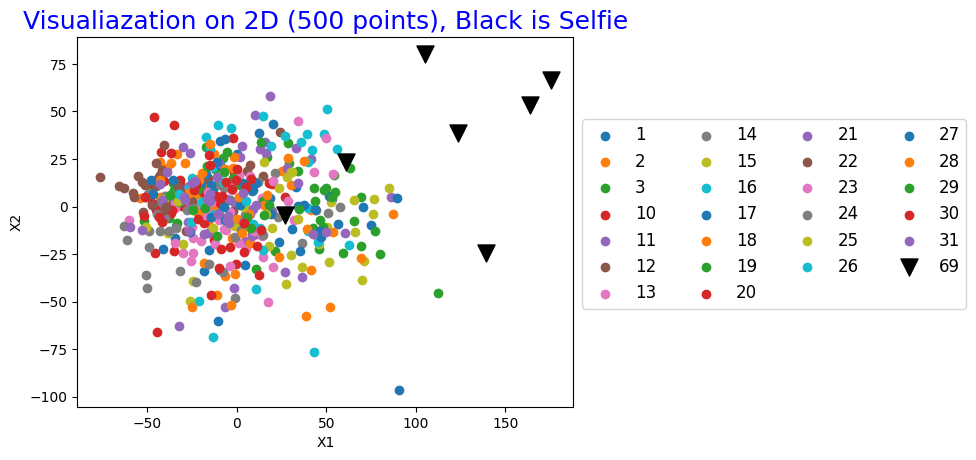

In [51]:
projected_data = PCA_projection(img=face_train, vec=vec).real
for i in np.unique(Labels):
    if i == 69:
        plt.scatter(projected_data[Labels == i][:,0],
            projected_data[Labels == i][:,1],
            s= 150,
            marker= 'v',
            c= 'black',
            label = i)
    else:
        plt.scatter(projected_data[Labels == i][:,0],
                    projected_data[Labels == i][:,1],
                    label = i)
plt.legend(ncol = 4,bbox_to_anchor = (1,.8),prop = {'size':12})
plt.title('Visualiazation on 2D (500 points), Black is Selfie',fontsize=18, color = 'b')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

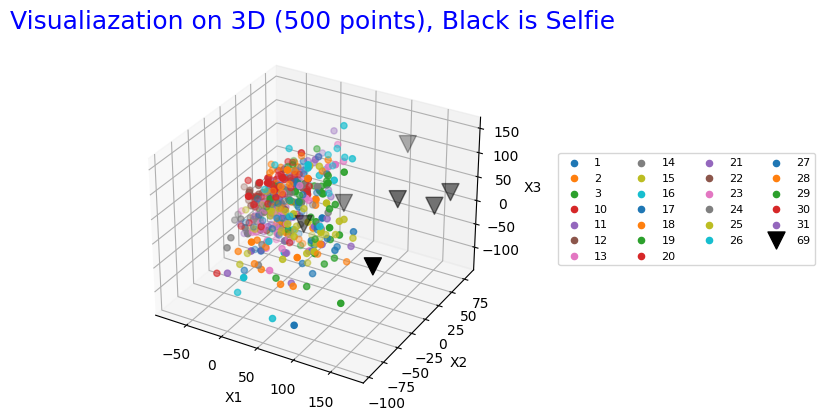

In [53]:
ax = plt.figure().add_subplot(projection='3d')
for i in np.unique(Labels):
    if i == 69:
        ax.scatter( projected_data[Labels == i][:,0],
                    projected_data[Labels == i][:,1],
                    projected_data[Labels == i][:,2],
                    s= 150,
                    marker= 'v',
                    c= 'black',
                    label = i)
    else:
        ax.scatter( projected_data[Labels == i][:,0],
                    projected_data[Labels == i][:,1],
                    projected_data[Labels == i][:,2],
                    label = i)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
plt.legend(ncol = 4,bbox_to_anchor = (1.15,.7),prop = {'size':8})
plt.title('Visualiazation on 3D (500 points), Black is Selfie', fontsize=18, color = 'b')
plt.show()

> 2. PCA plus nearest neighbor classification results

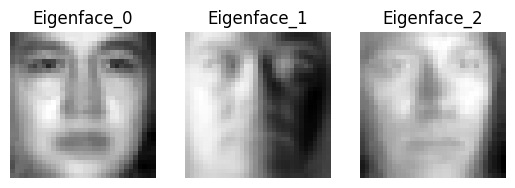

In [ ]:
Eigenfaces = (Vt-Vt.min())/(Vt.max() - Vt.min())*255
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(Eigenfaces[i].reshape(32,32), cmap='gray')
    plt.title(f'Eigenface_{i}')
    plt.axis('off')
plt.show()

In [ ]:
def KNN_classification(k, dim, X_test, y_test):
    distrances = np.linalg.norm(X_test[:, :dim][:, np.newaxis] - X_train[:, :dim], axis=2)
    distrances = np.argsort(distrances)  
    min_idx = distrances[:, :k]
    knn_labels = []
    for i in min_idx:
        y_pred = np.argmax(np.bincount(Label_train[i].astype(int)))
        knn_labels.append(y_pred)
    knn_labels = np.array(knn_labels)
    r_rate = np.sum(knn_labels == y_test) / len(y_test)
    return r_rate

def Print_result(X_test, y_test):
    for i in [40, 80 , 200 ]:
        print(f'Accuracy = {round(KNN_classification(k=1, dim=i, X_test=X_test, y_test=y_test)* 100, 1)}% | dim = {i}')
    print('---              | keep dim = 200')
    for k in [1, 2, 10, 200]:
        print(f'Accuracy = {round(KNN_classification(k=k, dim=200, X_test=X_test, y_test=y_test)* 100, 1)}% | k = {k}')

vec = PCA_decomponent(face_train)
X_train = PCA_projection(img=face_train, vec=vec)
PIE_test_projection = PCA_projection(img=PIE_test, vec=vec)
selfie_test_projection = PCA_projection(img=selfie_test, vec=vec)

print('-------------------------------------------------------')
print("For PIE:")
print('---              | keep k = 1')
Print_result(PIE_test_projection, PIE_label)
print('-------------------------------------------------------')
print("For selfie:")
print('---              | keep k = 1')
Print_result(selfie_test_projection, selfie_label)
print('-------------------------------------------------------')

-------------------------------------------------------
For PIE:
---              | keep k = 1
Accuracy = 51.8% | dim = 40
Accuracy = 52.8% | dim = 80
Accuracy = 55.2% | dim = 200
---              | keep dim = 200
Accuracy = 55.2% | k = 1
Accuracy = 42.1% | k = 2
Accuracy = 31.9% | k = 10
Accuracy = 9.4% | k = 200
-------------------------------------------------------
For selfie:
---              | keep k = 1
Accuracy = 0.0% | dim = 40
Accuracy = 0.0% | dim = 80
Accuracy = 0.0% | dim = 200
---              | keep dim = 200
Accuracy = 0.0% | k = 1
Accuracy = 0.0% | k = 2
Accuracy = 0.0% | k = 10
Accuracy = 0.0% | k = 200
-------------------------------------------------------
